## Purpose

I found this interesting diabetes dataset on the UCI ML repository that had time series data for 70 patients that was available [datasets](https://archive.ics.uci.edu/ml/datasets/Diabetes). 

I'd like to explore it thoroughly, but first I'll begin by looking at the data for only one patient.

[Formatting Data](#Formatting Data)

[Visualizing data](#Visualizing Data)

[Data Consolidation](#Data Consolidation)

[Modeling Data](#Modeling Data)

[Model Validation](#Model Validation)

## Formatting Data

<a id='Formatting Data'></a>

Interesting. I thought that the data that I was looking at was just blood glucose values at different times, with different events occurring. However, after reading this closer, it seems less clear that this may not necessarily be the case. Although there are a lot of reasonable values in the 'Value' field (eg. between 80-250), there are also a lot of 0-10 values which are not realistic. The documentation for the data isn't too useful. It just says that there is a code for the activity (which could've occurred at same datetime). 

I think that the 'Value' column isn't just blood-glucose, it's more realistic that it represents the value of the [code activity](https://archive.ics.uci.edu/ml/datasets/Diabetes). If that's the case, then I can just find the codes that I know are glucose measurements in order to get timelapse bg measurements :)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib nbagg

In [10]:
#Here's the key of codes:

codes= {
    33 : 'Regular insulin dose', 34 : 'NPH insulin dose', 
    35 : 'UltraLente insulin dose' ,48 : 'Unspecified blood glucose measurement', 
    57 : 'Unspecified blood glucose measurement', 58: 'Pre-breakfast blood glucose measurement', 
    59 : 'Post-breakfast blood glucose measurement', 60 : 'Pre-lunch blood glucose measurement', 
    61 : 'Post-lunch blood glucose measurement', 62 : 'Pre-supper blood glucose measurement', 
    63 : 'Post-supper blood glucose measurement', 64 : 'Pre-snack blood glucose measurement', 
    65 : 'Hypoglycemic symptoms', 66 : 'Typical meal ingestion', 
    67 : 'More-than-usual meal ingestion', 68 : 'Less-than-usual meal ingestion', 
    69 : 'Typical exercise activity', 70 : 'More-than-usual exercise activity', 
    71 : 'Less-than-usual exercise activity', 72 : 'Unspecified special event'
        }

glucose_codes= [48, 57, 58, 59, 60, 61, 62, 63, 64]
glucose_titles = [codes[48], codes[57], codes[58], codes[59], codes[60],
               codes[61], codes[62], codes[63], codes[64]]

In [11]:
data01= pd.read_csv('Diabetes-Data/data-01', sep= '\t', header = None)
data01.columns= ['date','time','code','bg_value']
data01.head()

,date,time,code,bg_value
0,04-21-1991,9:09,58,100
1,04-21-1991,9:09,33,9
2,04-21-1991,9:09,34,13
3,04-21-1991,17:08,62,119
4,04-21-1991,17:08,33,7


In [12]:
data01['datetime']= pd.to_datetime(data01['date']+' '+data01['time'])
data01= data01.drop(['date','time'], axis= 1)
data01.head()

,code,bg_value,datetime
0,58,100,1991-04-21 09:09:00
1,33,9,1991-04-21 09:09:00
2,34,13,1991-04-21 09:09:00
3,62,119,1991-04-21 17:08:00
4,33,7,1991-04-21 17:08:00


In [13]:
#Now let's filter the data so we only see glucose measurement data
glucoseOnly= data01[data01['code'].isin(glucose_codes)]


print 'These are the unique types of glucose measurements that are in our dataset: {}'.format(glucoseOnly['code'].unique())

glucoseOnly.head(5)

These are the unique types of glucose measurements that are in our dataset: [58 62 48 60]


,code,bg_value,datetime
0,58,100,1991-04-21 09:09:00
3,62,119,1991-04-21 17:08:00
5,48,123,1991-04-21 22:51:00
6,58,216,1991-04-22 07:35:00
10,62,211,1991-04-22 16:56:00


Excellent, now we know we only have codes 58, 62, 48, and 60 in our glucoseOnly table representing 'Pre-breakfast blood glucose measurement', 'Pre-supper blood glucose measurement', 'Unspecified blood glucose measurement', and 'Pre-lunch blood glucose measurement'.

Although there are other relevant codes, we can explore those later and at least visualize the data in the meantime.

## Visualizing Data

<a id='Visualizing Data'></a>

<IPython.core.display.Javascript object>


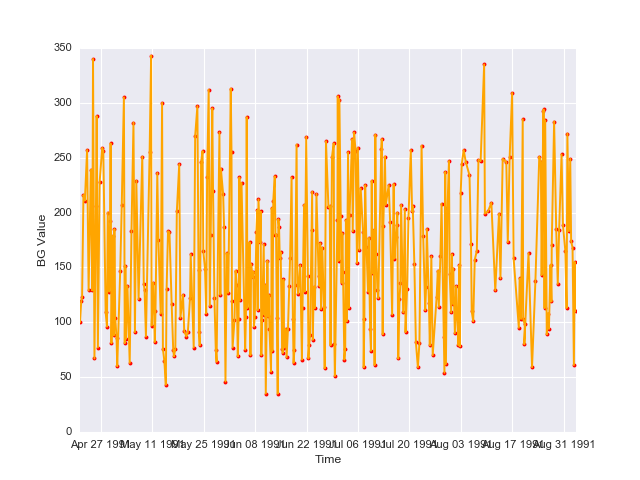

In [14]:
#Neat, now let's visualize the data over time!
plt.plot(glucoseOnly['datetime'], glucoseOnly['bg_value'], '.r')
plt.plot(glucoseOnly['datetime'], glucoseOnly['bg_value'], color= 'orange')
plt.xlabel('Time')
plt.ylabel('BG Value')

In [15]:
#One other thing I'd like to do is to visualize the rolling mean (moving average) of my data
#let's calculate that

bgMovingMean3= pd.rolling_mean(glucoseOnly['bg_value'],3, center=True)
print len(bgMovingMean3), len(glucoseOnly)

369 369


<IPython.core.display.Javascript object>


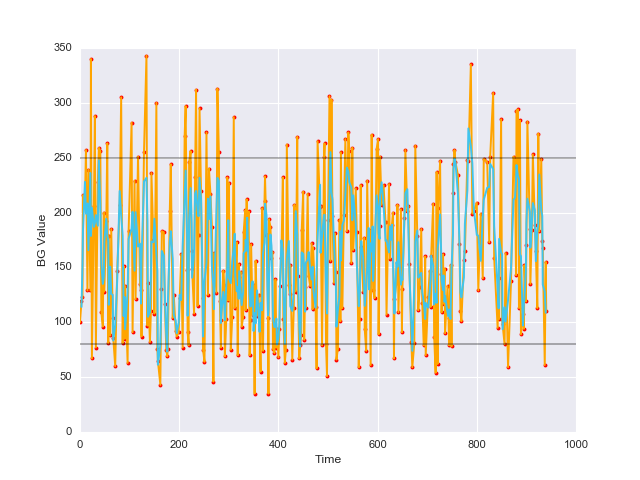

In [16]:
#Now let's plot the rolling average on top of these measurements
plt.plot(glucoseOnly['bg_value'], '.r')
plt.plot(glucoseOnly['bg_value'], color= 'orange')
plt.plot(pd.rolling_mean(glucoseOnly['bg_value'],3, center=True), color= '#40c4ed')

#Let's also plot the thresholds for typical thresholds (below healthy range= 80, and above range = 250)
plt.plot([250]*1000, marker= '_', color= 'k', alpha= 0.3)
plt.plot([80]*1000, marker= '_', color= 'k', alpha= 0.3)

plt.xlabel('Time')
plt.ylabel('BG Value')

For my next figure, I think it'd be neat to have an interactive plot of the raw data where I can hover over points and identify what the code was for that measurement! :)

In [17]:
%matplotlib inline

In [18]:
#Extra interactive Bokeh Figure

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import NumeralTickFormatter
from bokeh.models import DatetimeTickFormatter


output_notebook()

#We'll now make the source for the info on our hover
#The important thing to note is that for each one of our clusters (3)
#we'll have identical fields except for the indices we call to only 
#SELECT a subset of the data points we want for each cluster

source0= ColumnDataSource(data= dict(
        x= glucoseOnly['datetime'], y=  glucoseOnly['bg_value'],
        #marker_size= total_goals_for[indexCluster0]/1.5,
        #goals= datanumLabels['total_goals_for'].values[indexCluster0],
        title= glucoseOnly['code'].apply(lambda x: codes[x])))

# source1= ColumnDataSource(data= dict(
#         x= cluster1[:,0], y= cluster1[:,1],
#         marker_size= total_goals_for[indexCluster0]/1.5,
#         goals= datanumLabels['total_goals_for'].values[indexCluster1],
#         title= team_names[indexCluster1]))

#Then, when we use the hover tool to bring up our info when we hover, 
#all of them will follow the @title and the @goals assignments even
#though the data will come FROM different sources (0,1,2) for each cluster

hover= HoverTool(tooltips= [("Activity", " @title")])

#Initialize figure and define attributes
p = figure(plot_width=900, plot_height=500, tools=[hover, 'wheel_zoom', 'pan', 'reset'], 
           title= "Patient Blood Glucose Levels Over time)", title_text_font_size='18pt')

#Plot a figure for each cluster, calling a different source for each cluster
# p.circle('x', 'y', line_color= '#f2a02e', fill_color= '#f2a02e', fill_alpha= 0.3, source=source0,
#                            line_width= 4, size= 'marker_size')
p.line('x', 'y', line_color= '#f2a02e', source=source0)

#Finally, plot a 'skeleton' scatter plot that draws centroid for all points
#without using a data source
p.circle(glucoseOnly['datetime'], glucoseOnly['bg_value'], fill_color= 'red', line_color= 'red', source=source0)

#Now let's add the reference lines
p.line(glucoseOnly['datetime'], [250]*len(glucoseOnly['bg_value']), line_dash= 'dashed', line_color= 'black')
p.line(glucoseOnly['datetime'], [80]*len(glucoseOnly['bg_value']), line_dash= 'dashed', line_color= 'black')

#And finally the moving average
p.line(glucoseOnly['datetime'], bgMovingMean3, line_color= 'green')


p.xaxis[0].formatter = NumeralTickFormatter(format="0")
p.yaxis[0].formatter = NumeralTickFormatter(format="0")

p.xaxis.formatter=DatetimeTickFormatter(formats=dict(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    ))
p.xaxis.major_label_orientation = np.pi/4

p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Blood Glucose Level"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"

p.title_text_font_style = "bold"

show(p)

Loading BokehJS ...

## Data Consolidation

<a id='Data Consolidation'></a>

Now that I understand this data, I think it could be useful to put the data for ALL users into the same table. We could use the file suffix as the user_id as an extra column and potentially one hot encode the codes to turn them into features we could use. Let's first look at the files that are at our disposal. I know our files are in a subfolder called 'Diabetes-Data'.

In [19]:
import os 

subDir= os.listdir(os.getcwd() +'/Diabetes-Data')
print subDir

['data-01', 'data-02', 'data-03', 'data-04', 'data-05', 'data-06', 'data-07', 'data-08', 'data-09', 'data-10', 'data-11', 'data-12', 'data-13', 'data-14', 'data-15', 'data-16', 'data-17', 'data-18', 'data-19', 'data-20', 'data-21', 'data-22', 'data-23', 'data-24', 'data-25', 'data-26', 'data-27', 'data-28', 'data-29', 'data-30', 'data-31', 'data-32', 'data-33', 'data-34', 'data-35', 'data-36', 'data-37', 'data-38', 'data-39', 'data-40', 'data-41', 'data-42', 'data-43', 'data-44', 'data-45', 'data-46', 'data-47', 'data-48', 'data-49', 'data-50', 'data-51', 'data-52', 'data-53', 'data-54', 'data-55', 'data-56', 'data-57', 'data-58', 'data-59', 'data-60', 'data-61', 'data-62', 'data-63', 'data-64', 'data-65', 'data-66', 'data-67', 'data-68', 'data-69', 'data-70', 'Data-Codes', 'Domain-Description', 'README-DIABETES']


Ok so we know that there are 70 files. Our goal is to append the content of each table to a new dataframe that will contain the total data. This is how our workflow will work for each one:

1) Open new dataframe

2) Assign a userid that matches the item number in our iteration for all rows that belong to this file.

3) Perform a union to append the content of new dataframe to total dataframe.

Since our items of interest are the first 70 items in our list, we'll just start the loop there instead of doing regex to match requisites for our file title :)

In [72]:
#Initialize totalData dataframe

totalData= pd.DataFrame(columns= ['date','time','code','bg_value','uid'])

In [75]:
#Iterate through our directory list and concatenate rows from
#different users to totalData dataframe

for i in range(67,70):
    
    tempData= pd.read_csv('Diabetes-Data/' + subDir[i], sep= '\t', header = None)
    tempData.columns= ['date','time','code','bg_value']
    
    tempData['datetime']= pd.to_datetime(tempData['date']+' '+tempData['time'])
    tempData= tempData.drop(['date','time'], axis= 1)
    tempUid= [i+1]*len(tempData)
    tempData['uid']= tempUid
    totalData= pd.concat([totalData,tempData])

I got errors reading files 19 and 66. Basically they said that the number of days didn't match that particular month. So for now, I just skipped them. I'll also drop the 'date' and 'time' columns since I already added the 'datetime' column. (0,19), (20,66), (67,70)

In [76]:
totalData= totalData.drop(['date','time'], axis=1)
totalData.head()

,bg_value,code,datetime,uid
0,100,58.0,1991-04-21 09:09:00,1.0
1,9,33.0,1991-04-21 09:09:00,1.0
2,13,34.0,1991-04-21 09:09:00,1.0
3,119,62.0,1991-04-21 17:08:00,1.0
4,7,33.0,1991-04-21 17:08:00,1.0


In [79]:
#Now let's calculate the dimensions of our dataset and list the 
#unique uids in our table
print totalData.shape
totalData['uid'].unique()

(27360, 4)


array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  68.,
        69.,  70.])

In [80]:
#Finally, let's write this table to a csv 
#so that we can just load it later and make it available to others

totalData.to_csv('diabetes_total_data',header=True)

## Formatting Data

<a id='Formatting Data'></a>

## Formatting Data

<a id='Formatting Data'></a>

## Formatting Data

<a id='Formatting Data'></a>